# Project 1 

In [ ]:
!pip install wbdata
import wbdata

In [ ]:
import pandas as pd

In [ ]:
SOURCE = 40
indicators = wbdata.get_indicator(source = SOURCE)
indicators

id                 name
-----------------  -------------------------------------------------------------------
SH.DTH.0509        Number of deaths ages 5-9 years
SH.DTH.1014        Number of deaths ages 10-14 years
SH.DTH.1519        Number of deaths ages 15-19 years
SH.DTH.2024        Number of deaths ages 20-24 years
SH.DTH.IMRT        Number of infant deaths
SH.DTH.IMRT.FE     Number of infant deaths, female
SH.DTH.IMRT.MA     Number of infant deaths, male
SH.DTH.MORT        Number of under-five deaths
SH.DTH.MORT.FE     Number of under-five deaths, female
SH.DTH.MORT.MA     Number of under-five deaths, male
SH.DTH.NMRT        Number of neonatal deaths
SH.DYN.0509        Probability of dying among children ages 5-9 years (per 1,000)
SH.DYN.1014        Probability of dying among adolescents ages 10-14 years (per 1,000)
SH.DYN.1519        Probability of dying among adolescents ages 15-19 years (per 1,000)
SH.DYN.2024        Probability of dying among youth ages 20-24 years (per 1,000)

In [ ]:
wbdata.get_dataframe({"SP.POP.5559.MA":"Russia Population", "SP.POP.AG23.MA.IN": "hello"}, country="RUS")

,Russia Population,hello
date,,
2021,NaN,NaN
2020,4602435.0,682333.0
2019,4727216.0,734315.0
2018,4778335.0,785540.0
2017,4777615.0,835162.0
...,...,...
1964,2005496.0,849046.0
1963,1902053.0,1034048.0
1962,1801633.0,1240861.0


## [#A] Population Statistics

In [ ]:
def round_first(age):
  return max(0, age - age % 5)

def round_last(age):
  return age - age % 5 + 4


def population(year, sex, age_range, place):
  # find population dataframe for age range (currently assuming age_range values are multiple of 5; add interpolation in the future)
  variable_labels = []
  
  sex_postfix = "MA"
  if sex == "Female":
    sex_postfix = "FE"
  for i in range(round_first(age_range[0]), min(80, round_last(age_range[1])), 5):
    variable_labels.append("SP.POP." + f"{i:02d}" + f"{i+4:02d}" + "." + sex_postfix)
  
  # manually add 80UP 
  if age_range[1] >= 80:
    variable_labels.append("SP.POP.80UP." + sex_postfix)
    
  empty_dict = {}
  for i in variable_labels:
      empty_dict[i] = i
  pop = wbdata.get_dataframe(empty_dict, country=place)
  pop = pop.transpose()
  pop = pop[str(year)].sum()
  return pop

In [ ]:
population(year=1966,sex='Male',age_range=(18,26),place='RUS')

14827326.0

In [ ]:
# assert population(year=2000,sex='Male',age_range=(0,100),place='WLD') > 7e9
# This should be false because the male population should never be exceeding 7 billion in the year 2000 as that is the entire world population.

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np

## [#A] Population DataFrames



In [ ]:
def new_pop(place):
  # find population dataframe for age range (currently assuming age_range values are multiple of 5; add interpolation in the future)
  variable_labels_male = {}
  variable_labels_female = {}
  
  for i in range(0, 80, 5):
    variable_labels_male["SP.POP." + f"{i:02d}" + f"{i+4:02d}" + "." + 'MA'] = (i, i+4)
    variable_labels_female["SP.POP." + f"{i:02d}" + f"{i+4:02d}" + "." + 'FE'] = (i, i+4)
  
  # manually add 80UP 
  variable_labels_male["SP.POP.80UP." + 'MA'] = ('80 and up')
  variable_labels_female["SP.POP.80UP." + 'FE'] = ('80 and up')

  pop_m = wbdata.get_dataframe(variable_labels_male, country=place)
  pop_m = pop_m.transpose()
  pop_m = pop_m.stack().reset_index(-1).iloc[:, ::-1]
  pop_m = pop_m.reset_index()
  pop_m = pop_m.rename(columns={0: 'male', "index": "age group"})

  pop_f = wbdata.get_dataframe(variable_labels_female, country=place)
  pop_f = pop_f.transpose()
  pop_f = pop_f.stack().reset_index(-1).iloc[:, ::-1]
  pop_f = pop_f.reset_index()
  pop_f = pop_f.rename(columns={0: 'female', "index": "age group"})

  pop =  pd.merge(pop_m, pop_f,  how='left', left_on=['age group','date'], right_on = ['age group','date'])

  return pop

In [ ]:
new_pop(place='RUS')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



,age group,male,date,female
0,"(0, 4)",4703088.0,2020,4452313.0
1,"(0, 4)",4781058.0,2019,4524512.0
2,"(0, 4)",4838806.0,2018,4576591.0
3,"(0, 4)",4868384.0,2017,4602696.0
4,"(0, 4)",4843381.0,2016,4579788.0
...,...,...,...,...
1032,80 and up,318272.0,1964,923010.0
1033,80 and up,310111.0,1963,884717.0
1034,80 and up,297620.0,1962,841338.0
1035,80 and up,282229.0,1961,793681.0


## [#B] Population Pyramids

In [ ]:
def pop_pyramid(df):
  age_ranges = []
  # creating population pyramid in increments of 5 years
  for i in range(0,100,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

  age_ranges.append("80UP")

  layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 100], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'))

  # distinguishing between male and female (two sides of the pyramid)
  bins = [go.Bar(x = df['male'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='purple'),
               hoverinfo='skip'
               ),

        go.Bar(x = -df['female'],
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip',
               )
        ]
  py.iplot(dict(data=bins, layout=layout))

In [ ]:
pop_pyramid(new_pop(place='RUS'))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



## [#C] Animated Population Pyramids

In [ ]:
import ipywidgets
from ipywidgets import interactive, HBox, VBox
age_ranges = []
for i in range(0,80,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

age_ranges.append("80UP")

male_variables = {"SP.POP."+age_range+".MA":"Males "+age_range for age_range in age_ranges}
female_variables = {"SP.POP."+age_range+".FE":"Females "+age_range for age_range in age_ranges}

variables = male_variables
variables.update(female_variables)

df = wbdata.get_dataframe(variables,country="RUS")

def ani(df):
  # Count down by increments of 10 years
  years = range(2018,1960,-10)

  layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'))

  # Start with an empty list of age-rages
  age_ranges = []
  # Ranges top out at 80, and go in five year increments
  for i in range(0,80,5):
      age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
  age_ranges.append("80UP")

  # This makes a list of graphs, year by year
  bins = [go.Bar(x = df.loc[str(year),:].filter(regex="Male").values,
                y = [int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Men {:d}'.format(year),
                hoverinfo='skip'
                )
          for year in years]
          
  bins += [go.Bar(x = -df.loc[str(year),:].filter(regex="Male").values,
                y=[int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Women {:d}'.format(year),
                hoverinfo='skip',
               )
        for year in years]
      
  return py.iplot(dict(data=bins, layout=layout))


In [ ]:
import ipywidgets
from ipywidgets import interactive, HBox, VBox
age_ranges = []
for i in range(0,80,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

age_ranges.append("80UP")

male_variables = {"SP.POP."+age_range+".MA":"Males "+age_range for age_range in age_ranges}
female_variables = {"SP.POP."+age_range+".FE":"Females "+age_range for age_range in age_ranges}

variables = male_variables
variables.update(female_variables)

df = wbdata.get_dataframe(variables,country="RUS")

def ani(df):
  # Count down by increments of 10 years
  years = range(2018,1960,-10)

  layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'))

  # Start with an empty list of age-rages
  age_ranges = []
  # Ranges top out at 80, and go in five year increments
  for i in range(0,80,5):
      age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
  age_ranges.append("80UP")

  # This makes a list of graphs, year by year
  bins = [go.Bar(x = df.loc[str(year),:].filter(regex="Male").values,
                y = [int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Men {:d}'.format(year),
                hoverinfo='skip'
                )
          for year in years]
          
  bins += [go.Bar(x = -df.loc[str(year),:].filter(regex="Male").values,
                y=[int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Women {:d}'.format(year),
                hoverinfo='skip',
               )
        for year in years]
      
  py.iplot(dict(data=bins, layout=layout))

ipywidgets.interact(ani(df), year=(1960, 2018, 1))

In [ ]:
ani(df)

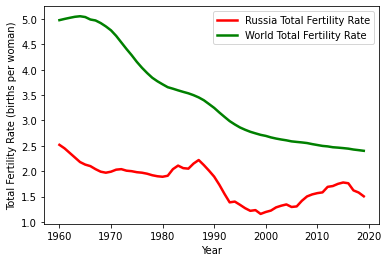

In [ ]:
# fertility rate visualization 
!pip install wbdata
import wbdata
import numpy as np
import pandas as pd
import cufflinks as cf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
cf.go_offline()
wbdata.get_country('RUS')

variable_labels = {"SP.DYN.TFRT.IN":"Russia Total Fertility Rate"}

RUS_FR = wbdata.get_dataframe(variable_labels, country="RUS")
RUS_FR = RUS_FR.reset_index()
# By Russian fertility from 1960 - 2020
RUS_FR['date'] = RUS_FR['date'].astype(int)
# By World fertility from 1960 - 2020
variable_labels = {"SP.DYN.TFRT.IN":"World Total Fertility Rate"}
WLD_FR = wbdata.get_dataframe(variable_labels, country="WLD")
WLD_FR = WLD_FR.reset_index()
WLD_FR['date'] = WLD_FR['date'].astype(int)

fig, ax = plt.subplots()
sns.lineplot(data=RUS_FR, x="date", y="Russia Total Fertility Rate", 
             label = 'Russia Total Fertility Rate', color='red', linewidth=2.5, dashes=(5, 1), ax = ax)
sns.lineplot(data=WLD_FR, x="date", y="World Total Fertility Rate", 
             label = 'World Total Fertility Rate', color='green', linewidth=2.5, ax = ax)



plt.xticks(np.arange(min(RUS_FR['date']), max(RUS_FR['date'])+1, 10))
ax.set(xlabel='Year', ylabel='Total Fertility Rate (births per woman)');

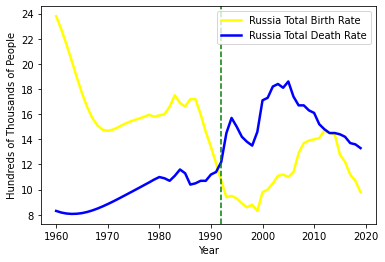

In [ ]:

# birth vs death rate
new_variable_label = {"SP.DYN.CBRT.IN":"Russia Total Birth Rate"}
# birth rate
RUS_BR = wbdata.get_dataframe(new_variable_label, country="RUS")
RUS_BR = RUS_BR.reset_index()

RUS_BR['date'] = RUS_BR['date'].astype(int)

next_variable_label = {"SP.DYN.CDRT.IN":"Russia Total Death Rate"}
# death rate
RUS_DR = wbdata.get_dataframe(next_variable_label, country="RUS")
RUS_DR = RUS_DR.reset_index()

RUS_DR['date'] = RUS_DR['date'].astype(int)

fig, ax = plt.subplots()
sns.lineplot(data=RUS_BR, x="date", y="Russia Total Birth Rate", 
             label = 'Russia Total Birth Rate', color='yellow', linewidth=2.5, dashes=(5, 1), ax = ax)
sns.lineplot(data=RUS_DR, x="date", y="Russia Total Death Rate", 
             label = 'Russia Total Death Rate', color='blue', linewidth=2.5, dashes=(5, 1), ax = ax)

# line indicates intersection point
plt.axvline(x = 1992, color = 'green', linestyle = '--')

plt.xticks(np.arange(min(RUS_BR['date']), max(RUS_BR['date'])+1, 10))
ax.set(xlabel='Year', ylabel='Hundreds of Thousands of People');

## Part C: Population Maps

In [ ]:
!pip install geopandas

In [ ]:
import geopandas

path_to_data = geopandas.datasets.get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."
